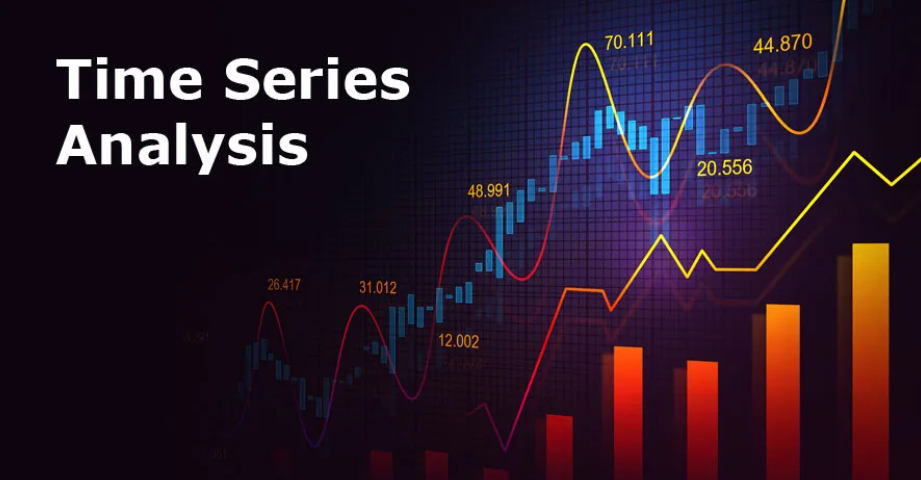

## For this challenge, you will be predicting a full year worth of sales for three items at two stores located in three different countries. 

### *Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.*

# <span class="title-section w3-xxlarge" style="color:#FF00FF" id="codebook">1.Load Packages </span>

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import warnings
# Matplotlib e Seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.express as px
init_notebook_mode()

#All stat packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# <span class="title-section w3-xxlarge" style="color:#FF00FF" id="codebook">2.Read Data </span>

In [ ]:
def read_data():
    train = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
    test = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')
    sub = pd.read_csv('../input/tabular-playground-series-jan-2022/sample_submission.csv')
    return train,test,sub

In [ ]:
%%time
train_df,test_df,sub_df = read_data()

In [ ]:
print('train set shape:', train_df.shape)
print('test set shape:', test_df.shape)

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
sub_df.head()

In [ ]:
train_df.describe()

# <span class="title-section w3-xxlarge" style="color:#FF00FF" id="codebook">3.EDA </span>

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of num_sold - for each store,  and product")
ax = sns.distplot(train_df['num_sold'])

Now we will compare our data to the normal distribution using Scipy normaltest:

In [ ]:
print("p-value for sales distribution: {}".format(st.normaltest(train_df.num_sold.values)[1]))
plt.figure(figsize=(12,5))
plt.title("Distribution of sales vs best fit normal distribution")
ax = sns.distplot(train_df.num_sold, fit= st.norm, kde=True, color='g')

In [ ]:
# Code (function) adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
def best_fit_distribution(data, bins= 200):
    """Model data by finding best fit distribution to data"""
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    DISTRIBUTIONS = [        
        st.alpha,st.beta,st.chi,st.chi2, st.dgamma,st.dweibull,st.erlang,st.exponweib,
        st.f, st.genexpon,st.gausshyper,st.gamma, st.johnsonsb,st.johnsonsu, st.norm,
        st.rayleigh,st.rice,st.recipinvgauss, st.t, st.weibull_min,st.weibull_max
    ]

    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:
        #print("Testing " + str(distribution))

        # Try to fit the distribution
        #try:
        # Ignore warnings from data that can't be fit
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')

            # fit dist to data
            params = distribution.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # identify if this distribution is better
            if best_sse > sse > 0:
                best_distribution = distribution
                best_params = params
                best_sse = sse
        #except Exception:
        #    pass

    return (best_distribution.name, best_params)

dist_name, best_params = best_fit_distribution(train_df.num_sold.values)
print("Best distribution found: {}, with parameters: {}".format(dist_name, best_params))

In [ ]:
plt.figure(figsize=(12,5))
plt.title("Distribution of sales vs Johnson-SB distribution (best fit)")
ax = sns.distplot(train_df.num_sold, fit= st.johnsonsb, kde=True, color='g')

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.1. Sales per store - bar chart </span>

In [ ]:
store_total = train_df.groupby(['store'])['num_sold'].sum().to_frame().reset_index()
store_total.sort_values(by = ['num_sold'], ascending=True, inplace=True)
labels = ['Store {}'.format(i) for i in store_total.store]

trace = go.Bar(
    y= store_total.num_sold, x= labels,
    marker=dict(color='rgba(255, 65, 54, 0.6)', line=dict(color='rgba(255, 65, 54, 1.0)', width=1)),
    name='Total sales per store', orientation='v'
)

layout = go.Layout(autosize=True, title= 'Total sales by store')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.2. Sales per country - bar chart </span>

In [ ]:
store_total = train_df.groupby(['country'])['num_sold'].sum().to_frame().reset_index()
store_total.sort_values(by = ['num_sold'], ascending=True, inplace=True)
labels = ['Country {}'.format(i) for i in store_total.country]

trace = go.Bar(
    y= store_total.num_sold, x= labels,
    marker=dict(color='rgba(255, 65, 54, 0.6)', line=dict(color='rgba(255, 65, 54, 1.0)', width=1)),
    name='Total sales per country', orientation='v'
)

layout = go.Layout(autosize=True, title= 'Total sales by country')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.3. Sales per country/Store/Product - bar chart </span>

In [ ]:
train_df['key'] = train_df['country']+'_'+ train_df['store']+'_'+train_df['product']
store_total = train_df.groupby(['key'])['num_sold'].sum().to_frame().reset_index()
store_total.sort_values(by = ['num_sold'], ascending=True, inplace=True)
labels = ['Key {}'.format(i) for i in store_total.key]

trace = go.Bar(
    y= store_total.num_sold, x= labels,
    marker=dict(color='rgba(255, 65, 54, 0.6)', line=dict(color='rgba(255, 65, 54, 1.0)', width=1)),
    name='Total sales per country/store/product', orientation='v'
)

layout = go.Layout(autosize=True, title= 'Total sales by country/store/product')
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.4. Sales by Box plot </span>

In [ ]:
store_sum = train_df.groupby(['store', 'date'])['num_sold'].sum().reset_index()
traces = []
for i, col in enumerate((store_sum['store'].unique())):
    s = store_sum[store_sum['store'] == col]
    trace = go.Box(y= s.num_sold, name= 'Store {}'.format(col), 
                   jitter=0.8, whiskerwidth=0.2,
                   marker=dict(size=2), line=dict(width=1))
    traces.append(trace)

layout = go.Layout(
    title='Sales BoxPlot for each store',
    yaxis=dict(
        autorange=True, showgrid=True, zeroline=True,
        gridcolor='rgb(233,233,233)', zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2, gridwidth=1
    ),
    margin=dict(l=40, r=30, b=80, t=100), showlegend=False,
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.5. Sales by Store and Time </span>

In [ ]:
data = []
for i, col in enumerate((store_sum['store'].unique())):
    s = store_sum[store_sum['store'] == col]
    trace = go.Scatter(
        x= s.date,
        y= s.num_sold,
        name = "Store "+str(col),
        opacity = 0.9)
    data.append(trace)

# Buttons to select a specific store visualization
update_buttons = []
for i, col in enumerate((store_sum['store'].unique())):
    visible = [True if j == i else False for j in range(store_sum['store'].nunique())]
    button= dict(label = 'Store ' + str(col), method= 'update', args= [{'visible': visible}])
    update_buttons.append(button)
# Button to return to all stores visualization
update_buttons.append(dict(label = 'All', method= 'update', args= [{'visible': [True]*10}]))

updatemenus = list([dict(active=-1, buttons=list(update_buttons))])

layout = dict(
    title='Sales by store and time',
    updatemenus= updatemenus,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=24, label='24m', step='month', stepmode='backward'),
                dict(count=36, label='36m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(), type='date'
    )
)

fig = dict(data=data, layout=layout)
iplot(fig, validate= False)

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">3.6. Sales by Key i.e., Store/Country/Product and Time </span>

In [ ]:
data = []
for i, col in enumerate((train_df['key'].unique())):
    s = train_df[train_df['key'] == col]
    trace = go.Scatter(
        x= s.date,
        y= s.num_sold,
        name = "Key "+str(col),
        opacity = 0.9)
    data.append(trace)

# Buttons to select a specific store visualization
update_buttons = []
for i, col in enumerate((train_df['key'].unique())):
    visible = [True if j == i else False for j in range(train_df['key'].nunique())]
    button= dict(label = 'Key ' + str(col), method= 'update', args= [{'visible': visible}])
    update_buttons.append(button)
# Button to return to all stores visualization
update_buttons.append(dict(label = 'All', method= 'update', args= [{'visible': [True]*10}]))

updatemenus = list([dict(active=-1, buttons=list(update_buttons))])

layout = dict(
    title='Sales by Key i.e, Country, Store and Product combination with time',
    updatemenus= updatemenus,
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(count=24, label='24m', step='month', stepmode='backward'),
                dict(count=36, label='36m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(), type='date'
    )
)
fig = dict(data=data, layout=layout)
iplot(fig, validate= False)

# <span class="title-section w3-xxlarge" style="color:#FF00FF" id="codebook">4.Stationarity Test </span>

#### Let us visualize for some of the keys or timeseries Ids

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">4.1. Stationarity test by Key i.e., Store/Country/Product and Time (Dickey Fuller) </span>


* This is a statistical test to determine the presence of a unit root in a time series data that confirms if the series is stationary or not. 

The null hypothesis is the time series is not stationary and has a unit root.
The alternate hypothesis is the time series is stationary and doesn't have a unit root.

Read more: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test
Read more: https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [ ]:
train_df['key'].unique()

In [ ]:
# let us visualize for only one store-country-product ie., timeseries ID
samp_df = train_df[train_df['key'] == 'Finland_KaggleMart_Kaggle Mug'][['date', 'num_sold']].reset_index(drop=True).set_index('date')

dftest = adfuller(samp_df.num_sold)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

We reject the null hypothesis if the value of the Test Statistic is less than the Critical Value at a significance level (1% or 5% or 10%). In this case it is (for all levels) and hence we CANNOT reject the null hypothesis and conclude that the series is NOT stationary


This way we can do stationarity test for all the different timeseries IDs

In [ ]:
fig = px.line(samp_df,  y='num_sold', title='Target variable ')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(width=800, height=600)
fig.show()

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">4.2. Trend and Seasonality by Key i.e., Store/Country/Product and Time </span>

In [ ]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(samp_df['num_sold'], period=12)
trend = result.trend
seasonal = result.seasonal
df_decomposed = pd.concat([trend, seasonal], axis = 1)
df_decomposed.columns = ['trend', 'seasonal']
fig = px.line(df_decomposed)
fig.update_layout(margin={'t': 40, 'b': 100, 'l': 50, 'r': 80},
       width=800, height=600)
fig.show()

## <span class="title-section w3-xlarge" style="color:#FF00FF" id="codebook">4.3. ACF and PACF plots by Key i.e., Store/Country/Product and Time </span>

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(45,35))
plot_acf(samp_df['num_sold'],lags=25)
plt.show()

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(45,35))
plot_pacf(samp_df['num_sold'],lags=25)
plt.show()

# <span class="title-section w3-xxlarge" style="color:#228B22" id="codebook">5.Work In Progress!!.............. </span>

## References

https://www.kaggle.com/jsaguiar/complete-eda-time-series-with-plotly